In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split


## Data Acquisition
##### Flat Acquisition using csv files

In [2]:
movies = pd.read_csv('./data/movies.csv')
ratings = pd.read_csv('./data/ratings.csv')
tags = pd.read_csv('./data/tags.csv')
genome_scores = pd.read_csv('./data/genome-scores.csv')
genome_tags = pd.read_csv('./data/genome-tags.csv')


In [3]:
# print the first 5 rows of the csv files
print('Movies:')
display(movies.head())
print('Ratings:')
display(ratings.head())
print('Tags:')
display(tags.head())
print('Genome Scores:')
display(genome_scores.head())
print('Genome Tags:')
display(genome_tags.head())


Movies:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Ratings:


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Tags:


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


Genome Scores:


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


Genome Tags:


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


### Data Wrangling

In [4]:
# ratings group by movieId with mean and count
grouped_ratings = ratings.groupby('movieId').agg({'rating': ['mean', 'count'], 'timestamp': ['mean']})
grouped_ratings.columns = ['mean_rating', 'rating_count', 'mean_timestamp']
grouped_ratings = grouped_ratings.astype({'mean_timestamp': 'int'})

# Dataset merge with movies and ratings, with missing rating films removed
df = pd.merge(movies, grouped_ratings, on='movieId')

display(df.head())


,movieId,title,genres,mean_rating,rating_count,mean_timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013


In [5]:
# Group by tagId and compute mean relevance
mean_relevance = genome_scores.groupby('tagId').mean()['relevance']

# Filter out tags with low mean relevance
threshold = 0.2
good_tags = mean_relevance.where(mean_relevance > threshold).dropna().index
genome_scores_2 = genome_scores[genome_scores['tagId'].isin(good_tags)]

# Merge movies with genome scores
genome_scores_2['tag'] = genome_scores_2['tagId'].map(genome_tags.set_index('tagId')['tag'].to_dict())
genome_table = genome_scores_2.pivot_table(index='movieId', columns='tag', values='relevance')

# Merge movies with genome table
df = pd.merge(df, genome_table, on='movieId', how='left')
display(df.head())

/tmp/ipykernel_6843/2056138442.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genome_scores_2['tag'] = genome_scores_2['tagId'].map(genome_tags.set_index('tagId')['tag'].to_dict())


,movieId,title,genres,mean_rating,rating_count,mean_timestamp,absurd,action,adaptation,adapted from:book,...,visceral,visual,visually appealing,visually stunning,weapons,weird,whimsical,witty,women,writers
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210,0.10400,0.66250,0.31675,0.28600,...,0.15150,0.56375,0.3150,0.67325,0.26375,0.42700,0.58700,0.69400,0.08925,0.14125
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117,0.15925,0.64025,0.51450,0.48450,...,0.07325,0.38150,0.2250,0.21700,0.17800,0.38650,0.29250,0.18725,0.13525,0.12225
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256,0.11375,0.16025,0.25200,0.19375,...,0.10175,0.10725,0.1960,0.09850,0.14125,0.24350,0.13025,0.22325,0.35075,0.12200
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471,0.13375,0.14700,0.50700,0.46175,...,0.08800,0.10750,0.2115,0.11625,0.28950,0.21975,0.14775,0.10725,0.97525,0.18200
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013,0.15475,0.15575,0.28925,0.19800,...,0.08275,0.11925,0.1850,0.11875,0.12025,0.29350,0.16425,0.10475,0.40225,0.19225


### Data Preparation (Data cleaning, Duplicates filtering, Data encoding)

##### Data Cleaning

In [6]:
# print number of rows
print('Number of rows: ', df.shape[0])

# fill rows with missing values (there are films with no tags, so we fill these tag columns set to 0)
df = df.fillna(0)

# print number of rows after dropping missing values
print('Number of rows after dropping missing values: ', df.shape[0])


Number of rows:  59047
Number of rows after dropping missing values:  59047


##### Data Encoding
Multicategorical One-Hot encoding for film genres

In [7]:
# one hot encoding for genres
categories = set()
for s in df['genres'].str.split('|').values:
    if s != ['(no genres listed)']:
        categories = categories.union(set(s))

print(categories)

# add columns for each category
for category in categories:
    df[category] = df['genres'].str.contains(category).astype(int)

# delete genres column
df = df.drop(columns=['genres'])

display(df.head())

{'Sci-Fi', 'Mystery', 'Thriller', 'Horror', 'IMAX', 'Romance', 'Musical', 'Documentary', 'Comedy', 'Fantasy', 'Action', 'Western', 'Animation', 'War', 'Film-Noir', 'Children', 'Crime', 'Adventure', 'Drama'}


,movieId,title,mean_rating,rating_count,mean_timestamp,absurd,action,adaptation,adapted from:book,adventure,...,Fantasy,Action,Western,Animation,War,Film-Noir,Children,Crime,Adventure,Drama
0,1,Toy Story (1995),3.893708,57309,1153152210,0.10400,0.66250,0.31675,0.28600,0.89375,...,1,0,0,1,0,0,1,0,1,0
1,2,Jumanji (1995),3.251527,24228,1122310117,0.15925,0.64025,0.51450,0.48450,0.97600,...,1,0,0,0,0,0,1,0,1,0
2,3,Grumpier Old Men (1995),3.142028,11804,980602256,0.11375,0.16025,0.25200,0.19375,0.32150,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),2.853547,2523,942460471,0.13375,0.14700,0.50700,0.46175,0.14875,...,0,0,0,0,0,0,0,0,0,1
4,5,Father of the Bride Part II (1995),3.058434,11714,1004723013,0.15475,0.15575,0.28925,0.19800,0.16350,...,0,0,0,0,0,0,0,0,0,0


##### Duplicates Filtering
The following results show that there are no duplicates in the dataset (as expected after merge operation).

In [8]:
# print number of rows
print('Number of rows: ', df.shape[0])

# drop duplicated rows
df = df.drop_duplicates()

# print number of rows after dropping missing values
print('Number of rows after dropping duplicated rows: ', df.shape[0])


Number of rows:  59047
Number of rows after dropping duplicated rows:  59047


## Data Visualization

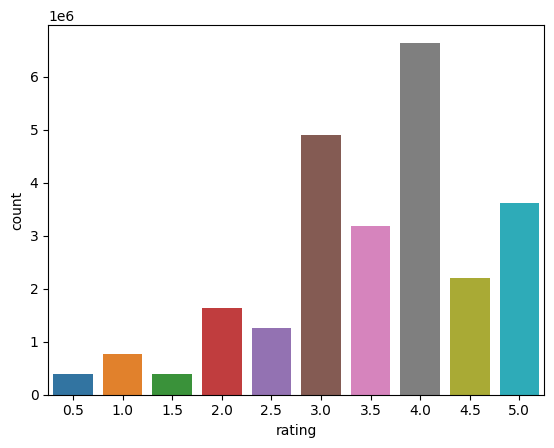

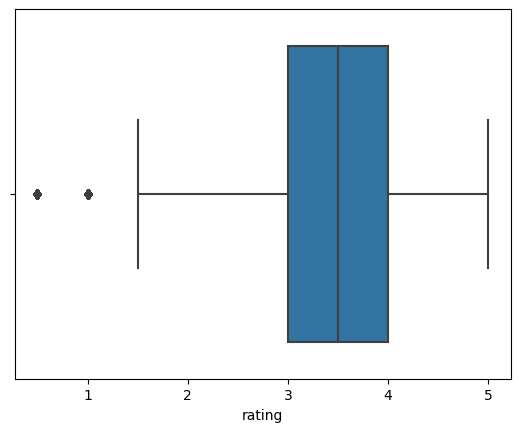

In [9]:
# rating distribution from ratings.csv
sns.countplot(x='rating', data=ratings)
plt.show()

sns.boxplot(x='rating', data=ratings)
plt.show()


Rather than using discrete bins, a KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate. This is used for continuous attributes like rating mean.

It is done to show differences after data aggregation in calculating mean for each film.

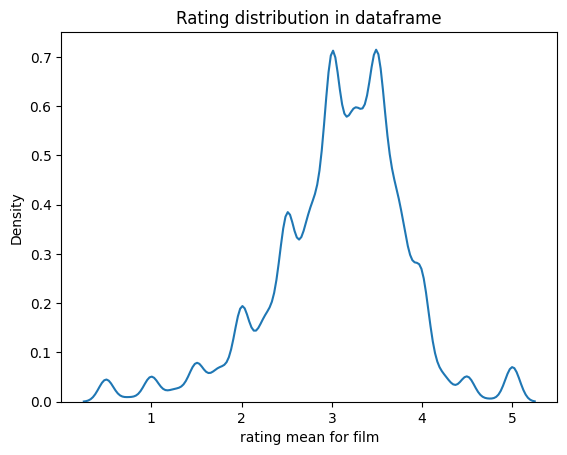

In [10]:
# rating distribution from df
sns.kdeplot(df['mean_rating'])
plt.xlabel('rating mean for film')
plt.title('Rating distribution in dataframe')
plt.show()


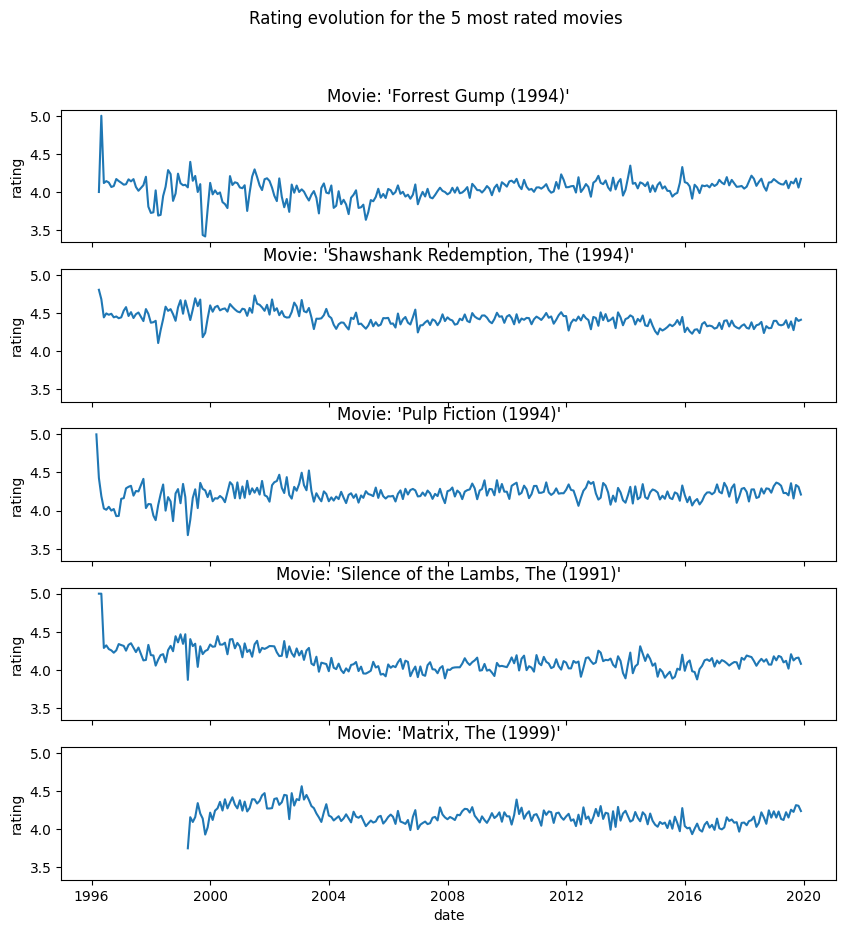

In [11]:
movies_to_show = 5
fig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))

most_rated_movies = ratings.groupby('movieId').count().sort_values('rating', ascending=False).head(movies_to_show).index

to_line_plot = []
for i in range(movies_to_show):
    tmp = ratings.where(ratings['movieId'] == most_rated_movies[i]).dropna()
    tmp['date'] = pd.to_datetime(tmp['timestamp'], unit='s')
    
    # Computing the mean for each month
    tmp = tmp.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    to_line_plot.append(tmp)
    movie_title = movies.where(movies['movieId'] == most_rated_movies[i]).dropna()['title'].values[0]
    axs[i].set_title("Movie: '" + movie_title + "'")
    

for i in range(movies_to_show):
    sns.lineplot(x='date', y='rating', ax=axs[i], data=to_line_plot[i])

fig.suptitle('Rating evolution for the 5 most rated movies')
plt.show()

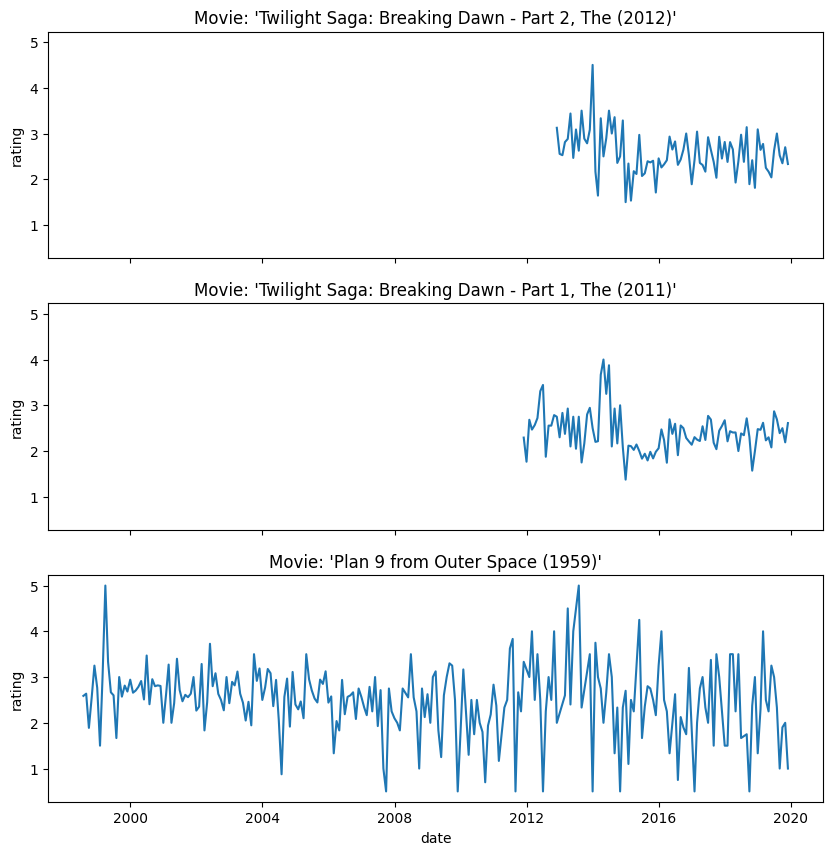

In [12]:
# Same as above cell but the 3 movies with the highest standard deviation
movies_to_show = 3
fig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))

# Take movies with at least 1000 ratings
high_std_movies = ratings.where(
    ratings['movieId']
    .isin(ratings.groupby('movieId')
          .count()
          .where(ratings.groupby('movieId').count()['rating'] > 1000)
          .dropna().index)
    ).dropna()

# most_rated_movies = ratings.groupby('movieId').count().sort_values('rating', ascending=False).head(movies_to_show).index
high_std_movies = high_std_movies.groupby('movieId').std().sort_values('rating', ascending=False).head(movies_to_show).index

to_line_plot = []
for i in range(movies_to_show):
    tmp = ratings.where(ratings['movieId'] == high_std_movies[i]).dropna()
    tmp['date'] = pd.to_datetime(tmp['timestamp'], unit='s')
    
    # Computing the mean for each month
    tmp = tmp.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    to_line_plot.append(tmp)
    movie_title = movies.where(movies['movieId'] == high_std_movies[i]).dropna()['title'].values[0]
    axs[i].set_title("Movie: '" + movie_title + "'")

for i in range(movies_to_show):
    sns.lineplot(x='date', y='rating', ax=axs[i], data=to_line_plot[i])

# Print the titles of the movies
plt.show()

Plot density for every attribute of dataset

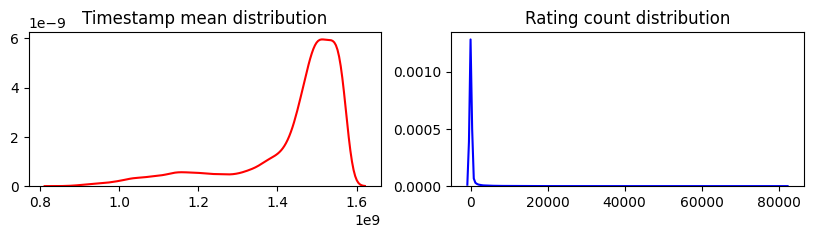

In [13]:
# print distribution for ratings
fig, axs = plt.subplots(1, 2, figsize=(10, 2))
sns.kdeplot(df['mean_timestamp'], ax=axs[0], color='r', label='timestamp')
sns.kdeplot(df['rating_count'], ax=axs[1], color='b', label='rating')

axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].title.set_text('Timestamp mean distribution')
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].title.set_text('Rating count distribution')
plt.show()


Number of movies with rating_count < 50:  45871
Number of all movies:  59047


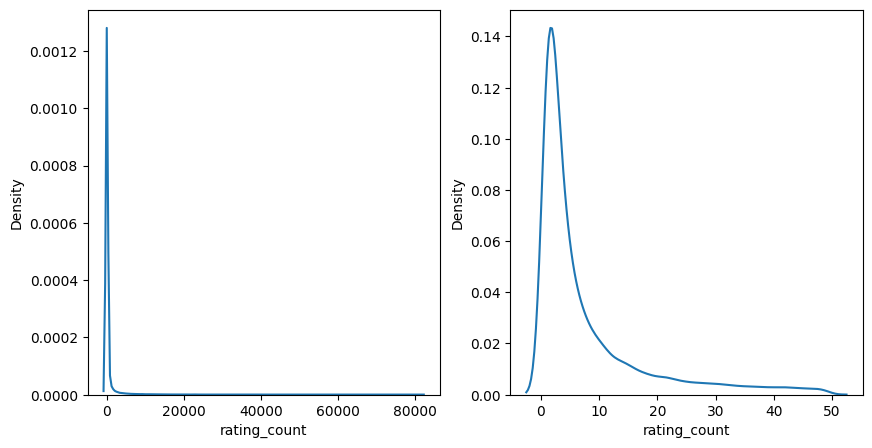

In [14]:
# density plot for rating_count
fig, axs = plt.subplots(1,2, figsize=(10, 5))
sns.kdeplot(df['rating_count'], ax=axs[0], label='rating_count')
sns.kdeplot(df['rating_count'].where(df['rating_count'] < 50), ax=axs[1], label='rating_count < 50')

print('Number of movies with rating_count < 50: ', df.where(df['rating_count'] < 50).count()[0])
print('Number of all movies: ', df.shape[0])

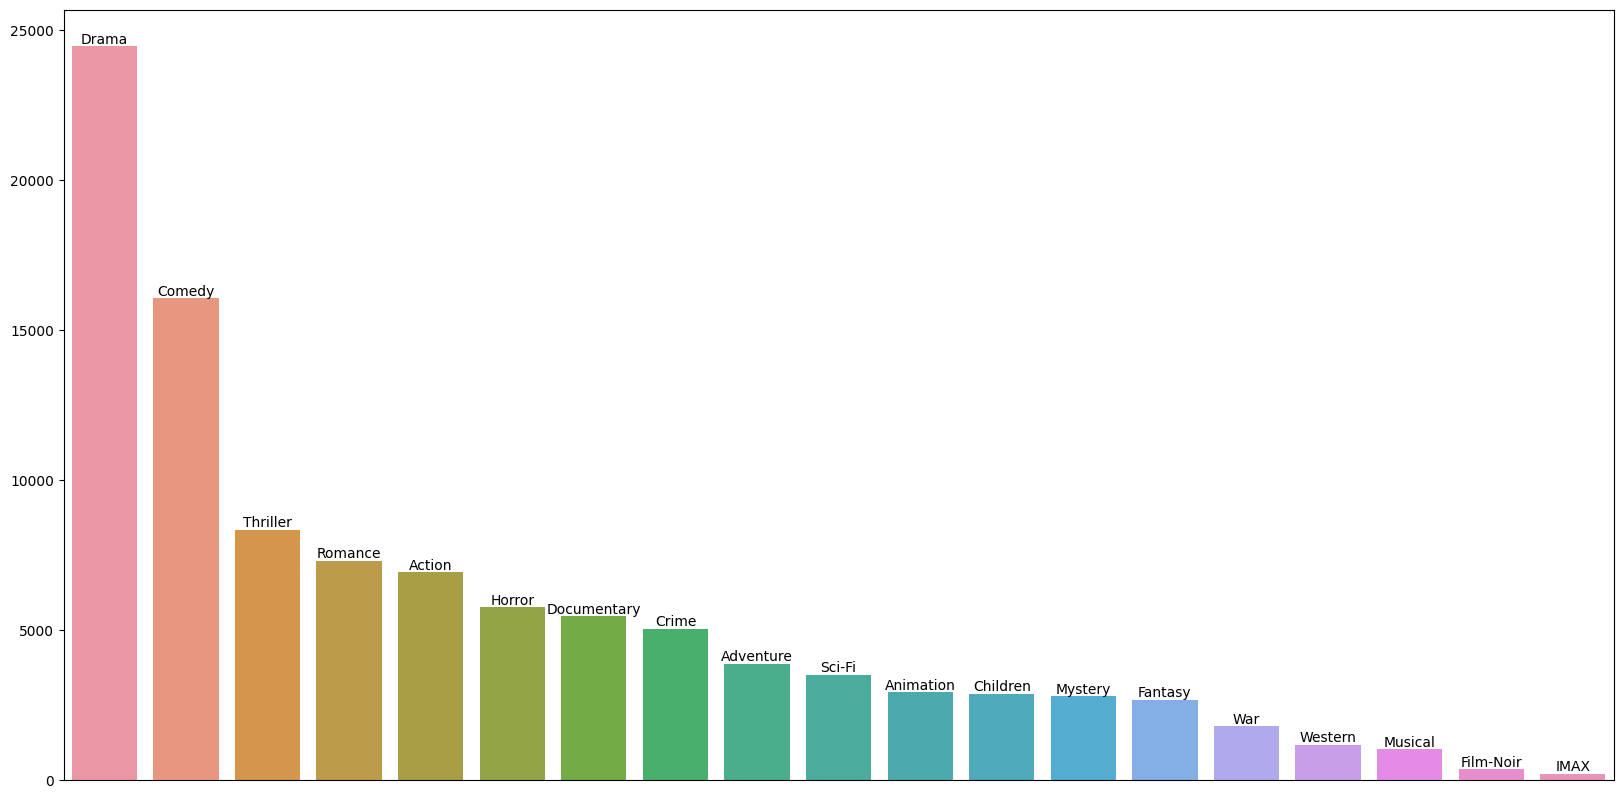

In [15]:
# plot for categories
cat = list(categories)

# count the number of rows containing 1 for each category
cat_dict = {}
for category in cat:
    cat_dict[category] = df[category].sum()

# order the dictionary by value in descending order
cat_dict = {k: v for k, v in sorted(cat_dict.items(), key=lambda item: item[1], reverse=True)}

# plot an histogram of the number of rows for each category
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.barplot(x=list(cat_dict.keys()), y=list(cat_dict.values()))
ax.bar_label(container=ax.containers[0], labels=list(cat_dict.keys()))
plt.xticks([])
plt.show()


In [16]:
""" # plot for tags

tag_columns = list(df.columns)
tag_columns = df.drop(columns=['movieId','title','mean_rating','rating_count', 'mean_timestamp']).columns
tag_columns = [tag for tag in tag_columns if tag not in categories]

tag_dict = {}
for tag in tag_columns:
    tag_dict[tag] = df[tag].mean()

# order the dictionary by value in descending order
tag_dict = {k: v for k, v in sorted(tag_dict.items(), key=lambda item: item[1], reverse=True)}

display('Tag mean: ', tag_dict)

# plot tag mean
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.barplot(x=list(tag_dict.keys()), y=list(tag_dict.values()))
ax.bar_label(container=ax.containers[0], labels=list(tag_dict.keys()))
plt.xticks([])
plt.show() """


" # plot for tags\n\ntag_columns = list(df.columns)\ntag_columns = df.drop(columns=['movieId','title','mean_rating','rating_count', 'mean_timestamp']).columns\ntag_columns = [tag for tag in tag_columns if tag not in categories]\n\ntag_dict = {}\nfor tag in tag_columns:\n    tag_dict[tag] = df[tag].mean()\n\n# order the dictionary by value in descending order\ntag_dict = {k: v for k, v in sorted(tag_dict.items(), key=lambda item: item[1], reverse=True)}\n\ndisplay('Tag mean: ', tag_dict)\n\n# plot tag mean\nfig, axs = plt.subplots(1, 1, figsize=(20, 10))\nax = sns.barplot(x=list(tag_dict.keys()), y=list(tag_dict.values()))\nax.bar_label(container=ax.containers[0], labels=list(tag_dict.keys()))\nplt.xticks([])\nplt.show() "

In [17]:
# count the number of rows containing 1 for Film-Noir and IMAX
print('Number of Film-Noir movies: ', df['Film-Noir'].sum())
print('Number of IMAX movies: ', df['IMAX'].sum())


Number of Film-Noir movies:  349
Number of IMAX movies:  195


## Data Preprocessing

In [18]:
# from title extract year
df['year'] = df['title'].str.extract('(\(\d{4}\))', expand=True)
# remove parentheses
df['year'] = df['year'].str.extract('(\d{4})', expand=True)

# remove movies with no year
df = df.dropna(subset=['year'])

# convert year to int
df['year'] = df['year'].astype(int)

# delete title and movieId columns
df = df.drop(columns=['movieId', 'title'])

display(df.head())

,mean_rating,rating_count,mean_timestamp,absurd,action,adaptation,adapted from:book,adventure,affectionate,allegory,...,Action,Western,Animation,War,Film-Noir,Children,Crime,Adventure,Drama,year
0,3.893708,57309,1153152210,0.10400,0.66250,0.31675,0.28600,0.89375,0.67625,0.24600,...,0,0,1,0,0,1,0,1,0,1995
1,3.251527,24228,1122310117,0.15925,0.64025,0.51450,0.48450,0.97600,0.12675,0.17750,...,0,0,0,0,0,1,0,1,0,1995
2,3.142028,11804,980602256,0.11375,0.16025,0.25200,0.19375,0.32150,0.09550,0.10775,...,0,0,0,0,0,0,0,0,0,1995
3,2.853547,2523,942460471,0.13375,0.14700,0.50700,0.46175,0.14875,0.13150,0.07750,...,0,0,0,0,0,0,0,0,1,1995
4,3.058434,11714,1004723013,0.15475,0.15575,0.28925,0.19800,0.16350,0.11875,0.06975,...,0,0,0,0,0,0,0,0,0,1995


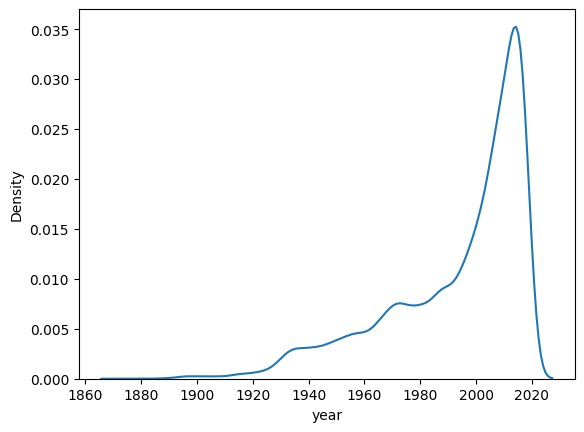

In [19]:
# density plot for film year
sns.kdeplot(df['year'])
plt.show()

mean_rating : (array([0.5       , 0.58333333, 0.6       , ..., 4.75      , 4.83333333,
       5.        ]), array([528,   1,   2, ...,  51,   4, 828]))
mean_timestamp : (array([ 858548920,  865246697,  872675452, ..., 1574286714, 1574291826,
       1574291937]), array([1, 1, 1, ..., 1, 1, 1]))
year : (array([1874, 1878, 1880, 1883, 1887, 1888, 1890, 1891, 1892, 1894, 1895,
       1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906,
       1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917,
       1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928,
       1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 198

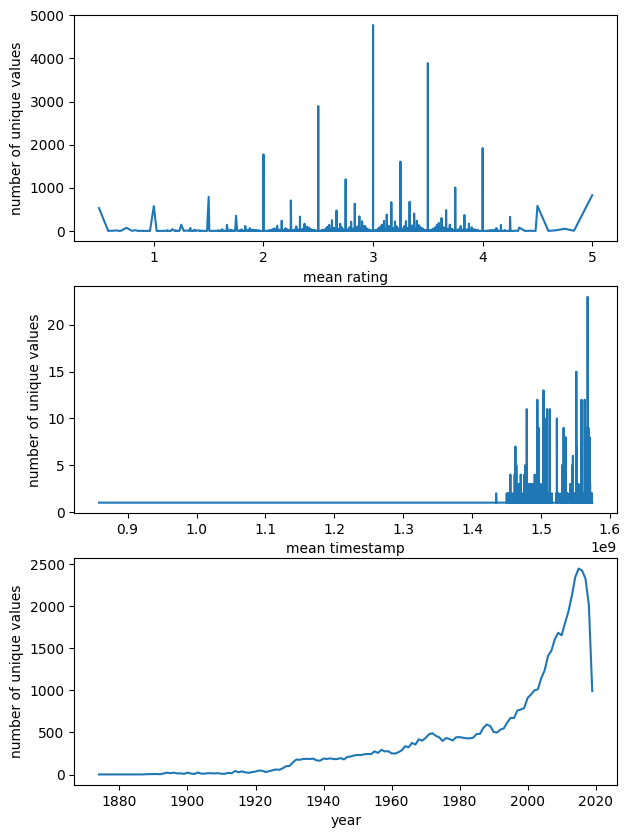

In [20]:
# Compute the number of unique values for each column
unique_values = {}
for column in df.columns:
    if column == 'mean_rating' or column == 'mean_timestamp' or column == 'year':
        unique_values[column] = np.unique(df[column], return_counts=True)

# Print the number of unique values for each column
for column in unique_values:
    print(column, ':', unique_values[column])

# Plot the number of unique values for each column
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 10))
sns.lineplot(x=unique_values['mean_rating'][0], y=unique_values['mean_rating'][1], ax=axs[0])
axs[0].set_xlabel('mean rating')
axs[0].set_ylabel('number of unique values')
sns.lineplot(x=unique_values['mean_timestamp'][0], y=unique_values['mean_timestamp'][1], ax=axs[1])
axs[1].set_xlabel('mean timestamp')
axs[1].set_ylabel('number of unique values')
sns.lineplot(x=unique_values['year'][0], y=unique_values['year'][1], ax=axs[2])
axs[2].set_xlabel('year')
axs[2].set_ylabel('number of unique values')
plt.show()


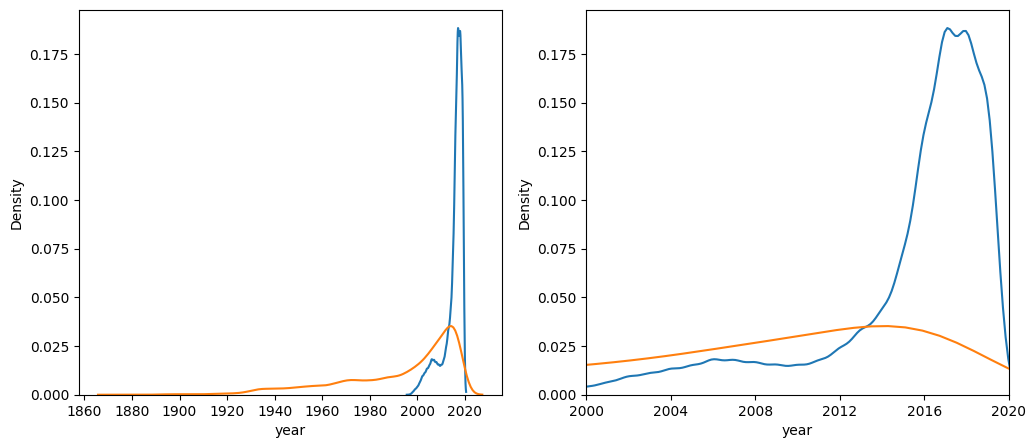

In [21]:
# show year and year_timestamp in the same plot with values from 2000 to 2020
df_year = df.copy()
df_year['mean_timestamp'] = pd.to_datetime(df['mean_timestamp'], unit='s')
df_year['year_timestamp'] = df_year['mean_timestamp'].dt.year

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.kdeplot(df_year['year_timestamp'], ax=axs[0], label='timestamp year')
sns.kdeplot(df_year['year'], ax=axs[0], label='film year')
axs[0].set_xlabel('year')
sns.kdeplot(df_year['year_timestamp'], ax=axs[1], label='timestamp year')
sns.kdeplot(df_year['year'], ax=axs[1], label='film year')
axs[1].set_xlabel('year')
axs[1].set_xlim(2000, 2020)
axs[1].set_xticks(np.arange(2000, 2022, 4))
plt.show()


In [22]:
# Drop columns that are in cat but not in lower_case_tags
lower_case_tags = [str.lower(t) for t in genome_tags['tag'].values]
cat = list(categories)
for c in cat:
    if c.lower() in lower_case_tags:
        df = df.drop(columns=[c])
        print('Dropped column', c)

display(df.head())


Dropped column Sci-Fi
Dropped column Mystery
Dropped column Thriller
Dropped column Horror
Dropped column Romance
Dropped column Musical
Dropped column Documentary
Dropped column Comedy
Dropped column Fantasy
Dropped column Action
Dropped column Western
Dropped column Animation
Dropped column War
Dropped column Children
Dropped column Crime
Dropped column Adventure
Dropped column Drama


,mean_rating,rating_count,mean_timestamp,absurd,action,adaptation,adapted from:book,adventure,affectionate,allegory,...,visually stunning,weapons,weird,whimsical,witty,women,writers,IMAX,Film-Noir,year
0,3.893708,57309,1153152210,0.10400,0.66250,0.31675,0.28600,0.89375,0.67625,0.24600,...,0.67325,0.26375,0.42700,0.58700,0.69400,0.08925,0.14125,0,0,1995
1,3.251527,24228,1122310117,0.15925,0.64025,0.51450,0.48450,0.97600,0.12675,0.17750,...,0.21700,0.17800,0.38650,0.29250,0.18725,0.13525,0.12225,0,0,1995
2,3.142028,11804,980602256,0.11375,0.16025,0.25200,0.19375,0.32150,0.09550,0.10775,...,0.09850,0.14125,0.24350,0.13025,0.22325,0.35075,0.12200,0,0,1995
3,2.853547,2523,942460471,0.13375,0.14700,0.50700,0.46175,0.14875,0.13150,0.07750,...,0.11625,0.28950,0.21975,0.14775,0.10725,0.97525,0.18200,0,0,1995
4,3.058434,11714,1004723013,0.15475,0.15575,0.28925,0.19800,0.16350,0.11875,0.06975,...,0.11875,0.12025,0.29350,0.16425,0.10475,0.40225,0.19225,0,0,1995


In [23]:
""" # TODO - balancing dataset only for training set
# remove samples_to_drop movies with mean_rating between 2.5 and 4
samples_to_drop = 25000
df_preprocessed = df.copy()
df_preprocessed = df_preprocessed.drop(df_preprocessed[(df_preprocessed['mean_rating'] >= 2.5) & (df_preprocessed['mean_rating'] <= 4)].sample(samples_to_drop).index)

# rating distribution from df
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(df['mean_rating'], ax=axs[0])
sns.kdeplot(df_preprocessed['mean_rating'], ax=axs[1])
plt.xlabel('rating mean for film')
plt.title('Rating distribution in dataframe')
plt.show()

# number of samples in df and df_preprocessed
print('Number of samples in df: ', df.shape[0])
print('Number of samples in df_preprocessed: ', df_preprocessed.shape[0]) """


" # TODO - balancing dataset only for training set\n# remove samples_to_drop movies with mean_rating between 2.5 and 4\nsamples_to_drop = 25000\ndf_preprocessed = df.copy()\ndf_preprocessed = df_preprocessed.drop(df_preprocessed[(df_preprocessed['mean_rating'] >= 2.5) & (df_preprocessed['mean_rating'] <= 4)].sample(samples_to_drop).index)\n\n# rating distribution from df\nfig, axs = plt.subplots(1, 2, figsize=(10, 5))\nsns.kdeplot(df['mean_rating'], ax=axs[0])\nsns.kdeplot(df_preprocessed['mean_rating'], ax=axs[1])\nplt.xlabel('rating mean for film')\nplt.title('Rating distribution in dataframe')\nplt.show()\n\n# number of samples in df and df_preprocessed\nprint('Number of samples in df: ', df.shape[0])\nprint('Number of samples in df_preprocessed: ', df_preprocessed.shape[0]) "

### Normalization

In [24]:
# TODO - fit the model to raw, scaled and standardized data and compare the performance for best results

mean_rating_column = df['mean_rating']

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df.drop(columns=['mean_rating']))

# show normalized data
df = pd.DataFrame(normalized_data, columns=df.columns[:-1])
df['mean_rating'] = mean_rating_column
df = df.dropna()
mean_rating_column = df['mean_rating']
display(df.shape)


(58308, 204)

### Correlation results
This correlation table shows the relationship between different movie genres and several movie characteristics such as mean rating, rating count, and year of release. The values in the table represent the Pearson correlation coefficient, which ranges from -1 to 1 and measures the linear association between two variables. Positive values indicate a positive association, meaning that as one variable increases, the other variable also increases. Negative values indicate a negative association, meaning that as one variable increases, the other variable decreases.

<!-- Some observations from the table:

There is a positive correlation between the mean rating and rating count of a movie (0.13). This indicates that movies with higher ratings tend to have more ratings.
Film-Noir has a moderate positive correlation with Crime (0.15) and Mystery (0.06). This suggests that movies classified as Film-Noir often have elements of crime and mystery.
Horror movies have a negative correlation with mean rating (-0.22), indicating that they tend to have lower ratings.
Drama movies have a moderate positive correlation with mean rating (0.15) and a moderate positive correlation with Thriller movies (0.24).
There is a negative correlation between year of release and rating count (-0.27), which suggests that older movies tend to have fewer ratings.
In conclusion, this table provides useful information about the relationship between different movie genres and movie characteristics, and can be used to make informed decisions about movie selection and production. -->

### Covariance results
Covariance is a measure of the linear relationship between two variables. It measures how changes in one variable are associated with changes in the other variable. Covariance is expressed as a numerical value and can range from negative to positive values. A positive covariance means that the two variables are positively related, while a negative covariance means that they are inversely related. A covariance of zero means that there is no linear relationship between the variables (i.e. variables are indipendent).

<!-- In the table provided, the covariance between two variables can be found in the entries of the matrix. For example, the covariance between "mean_rating" and "Film-Noir" is 0.001774, indicating a very small positive relationship between the two variables. The covariance between "rating_count" and "Crime" is 43.331685, indicating a stronger positive relationship between these two variables.

It's important to keep in mind that covariance only measures linear relationships, so it may not be able to fully capture more complex relationships between variables.

As it's possible to see in the table, variables tend to be indipendent from each others, this is not valid only for two variables: rating_count and mean_timestamp. These two attributes are highly dipendent with all other attributes. -->

### Dataset Describe
The describe() function applied on the Pandas DataFrame provides statistical information about the features in the DataFrame. According to the results, the mean rating for the movies is 3.110263, with a standard deviation of 0.653225. The minimum and maximum ratings are 0.5 and 5, respectively. The mean count of ratings for each movie is 596.81, with a standard deviation of 2929.96.

<!-- The genre columns (Film-Noir, Crime, Mystery, Animation, etc.) are binary, with a mean of either 0 or 0.01 to 0.28. The 25th, 50th, and 75th percentiles for these features are either 0 or close to 0, indicating that the majority of the movies belong to a particular genre. The year_timestamp feature has a mean of 2014.22, with a standard deviation of 4.7. The year feature has a mean of 1991.57 and a standard deviation of 25.09. -->


                mean_rating  rating_count  mean_timestamp  Film-Noir      IMAX
mean_rating        1.000000     -0.069833        0.100282  -0.030876  0.032317
rating_count      -0.069833      1.000000       -0.479314   0.149884 -0.047162
mean_timestamp     0.100282     -0.479314        1.000000   0.039524  0.016501
Film-Noir         -0.030876      0.149884        0.039524   1.000000 -0.116652
IMAX               0.032317     -0.047162        0.016501  -0.116652  1.000000
                mean_rating  rating_count  mean_timestamp  Film-Noir      IMAX
mean_rating        0.539849     -0.010026        0.009888  -0.003883  0.001829
rating_count      -0.010026      0.038179       -0.012568   0.005013 -0.000710
mean_timestamp     0.009888     -0.012568        0.018010   0.000908  0.000171
Film-Noir         -0.003883      0.005013        0.000908   0.029302 -0.001538
IMAX               0.001829     -0.000710        0.000171  -0.001538  0.005933
        mean_rating  rating_count  mean_timestamp   

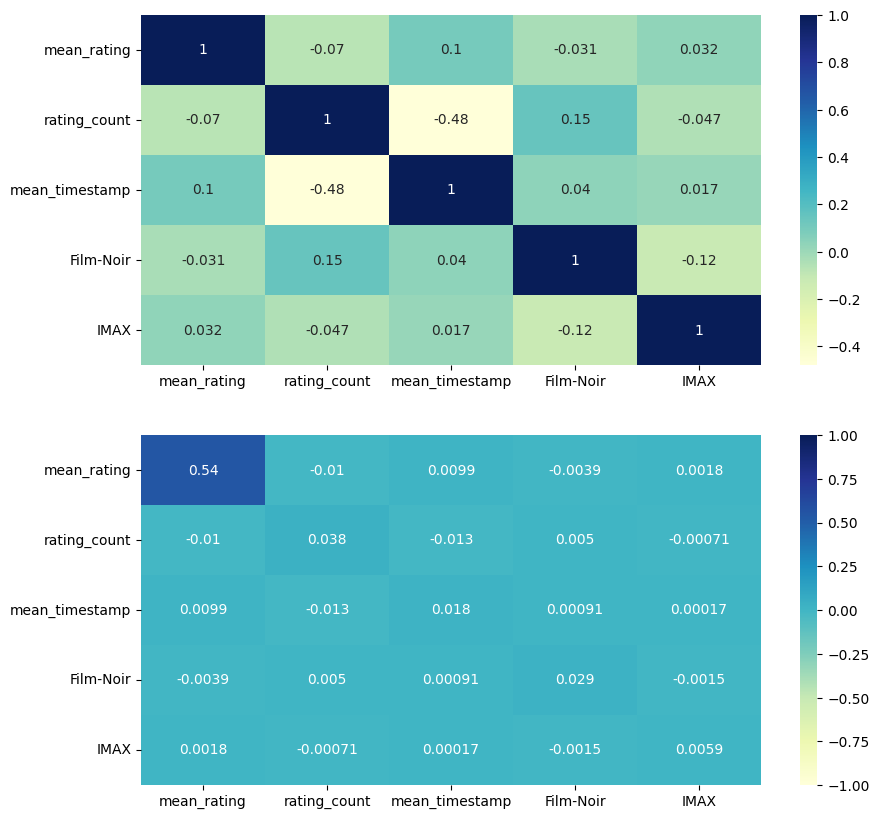

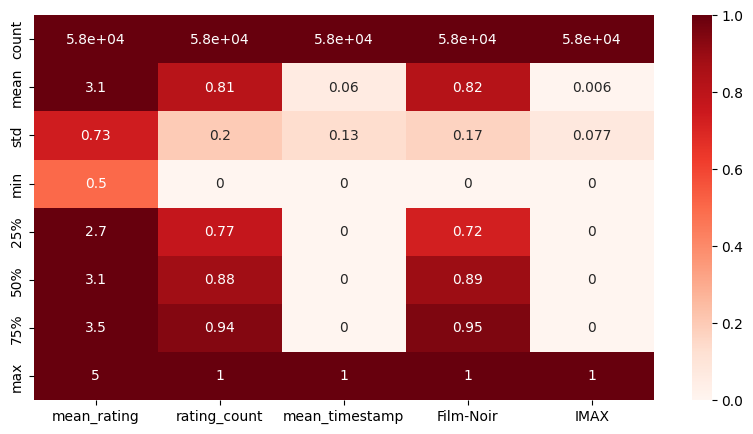

In [25]:
# compute analysis for 'mean_rating', 'rating_count', 'mean_timestamp', 'Film-Noir', 'IMAX'
corr = df[['mean_rating', 'rating_count', 'mean_timestamp', 'Film-Noir', 'IMAX']].corr()
print(corr)
cov = df[['mean_rating', 'rating_count', 'mean_timestamp', 'Film-Noir', 'IMAX']].cov()
print(cov)
desc = df[['mean_rating', 'rating_count', 'mean_timestamp', 'Film-Noir', 'IMAX']].describe()
print(desc)

# follow examples from slides on Data Visualization (pages 6-8)
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# show results of correlation in a graphic way
# Plot the heatmap of the correlation matrix
sns.heatmap(corr, annot=True, cmap="YlGnBu", ax=axs[0])
# show results of covariance in a graphic way
# Plot the heatmap of the covariance matrix
sns.heatmap(cov, annot=True, cmap="YlGnBu", ax=axs[1], vmax=1, vmin=-1)

plt.show()

# Plot the table
plt.figure(figsize=(10, 5))
sns.heatmap(desc, annot=True, cmap='Reds', vmax=1, vmin=0)
plt.show()




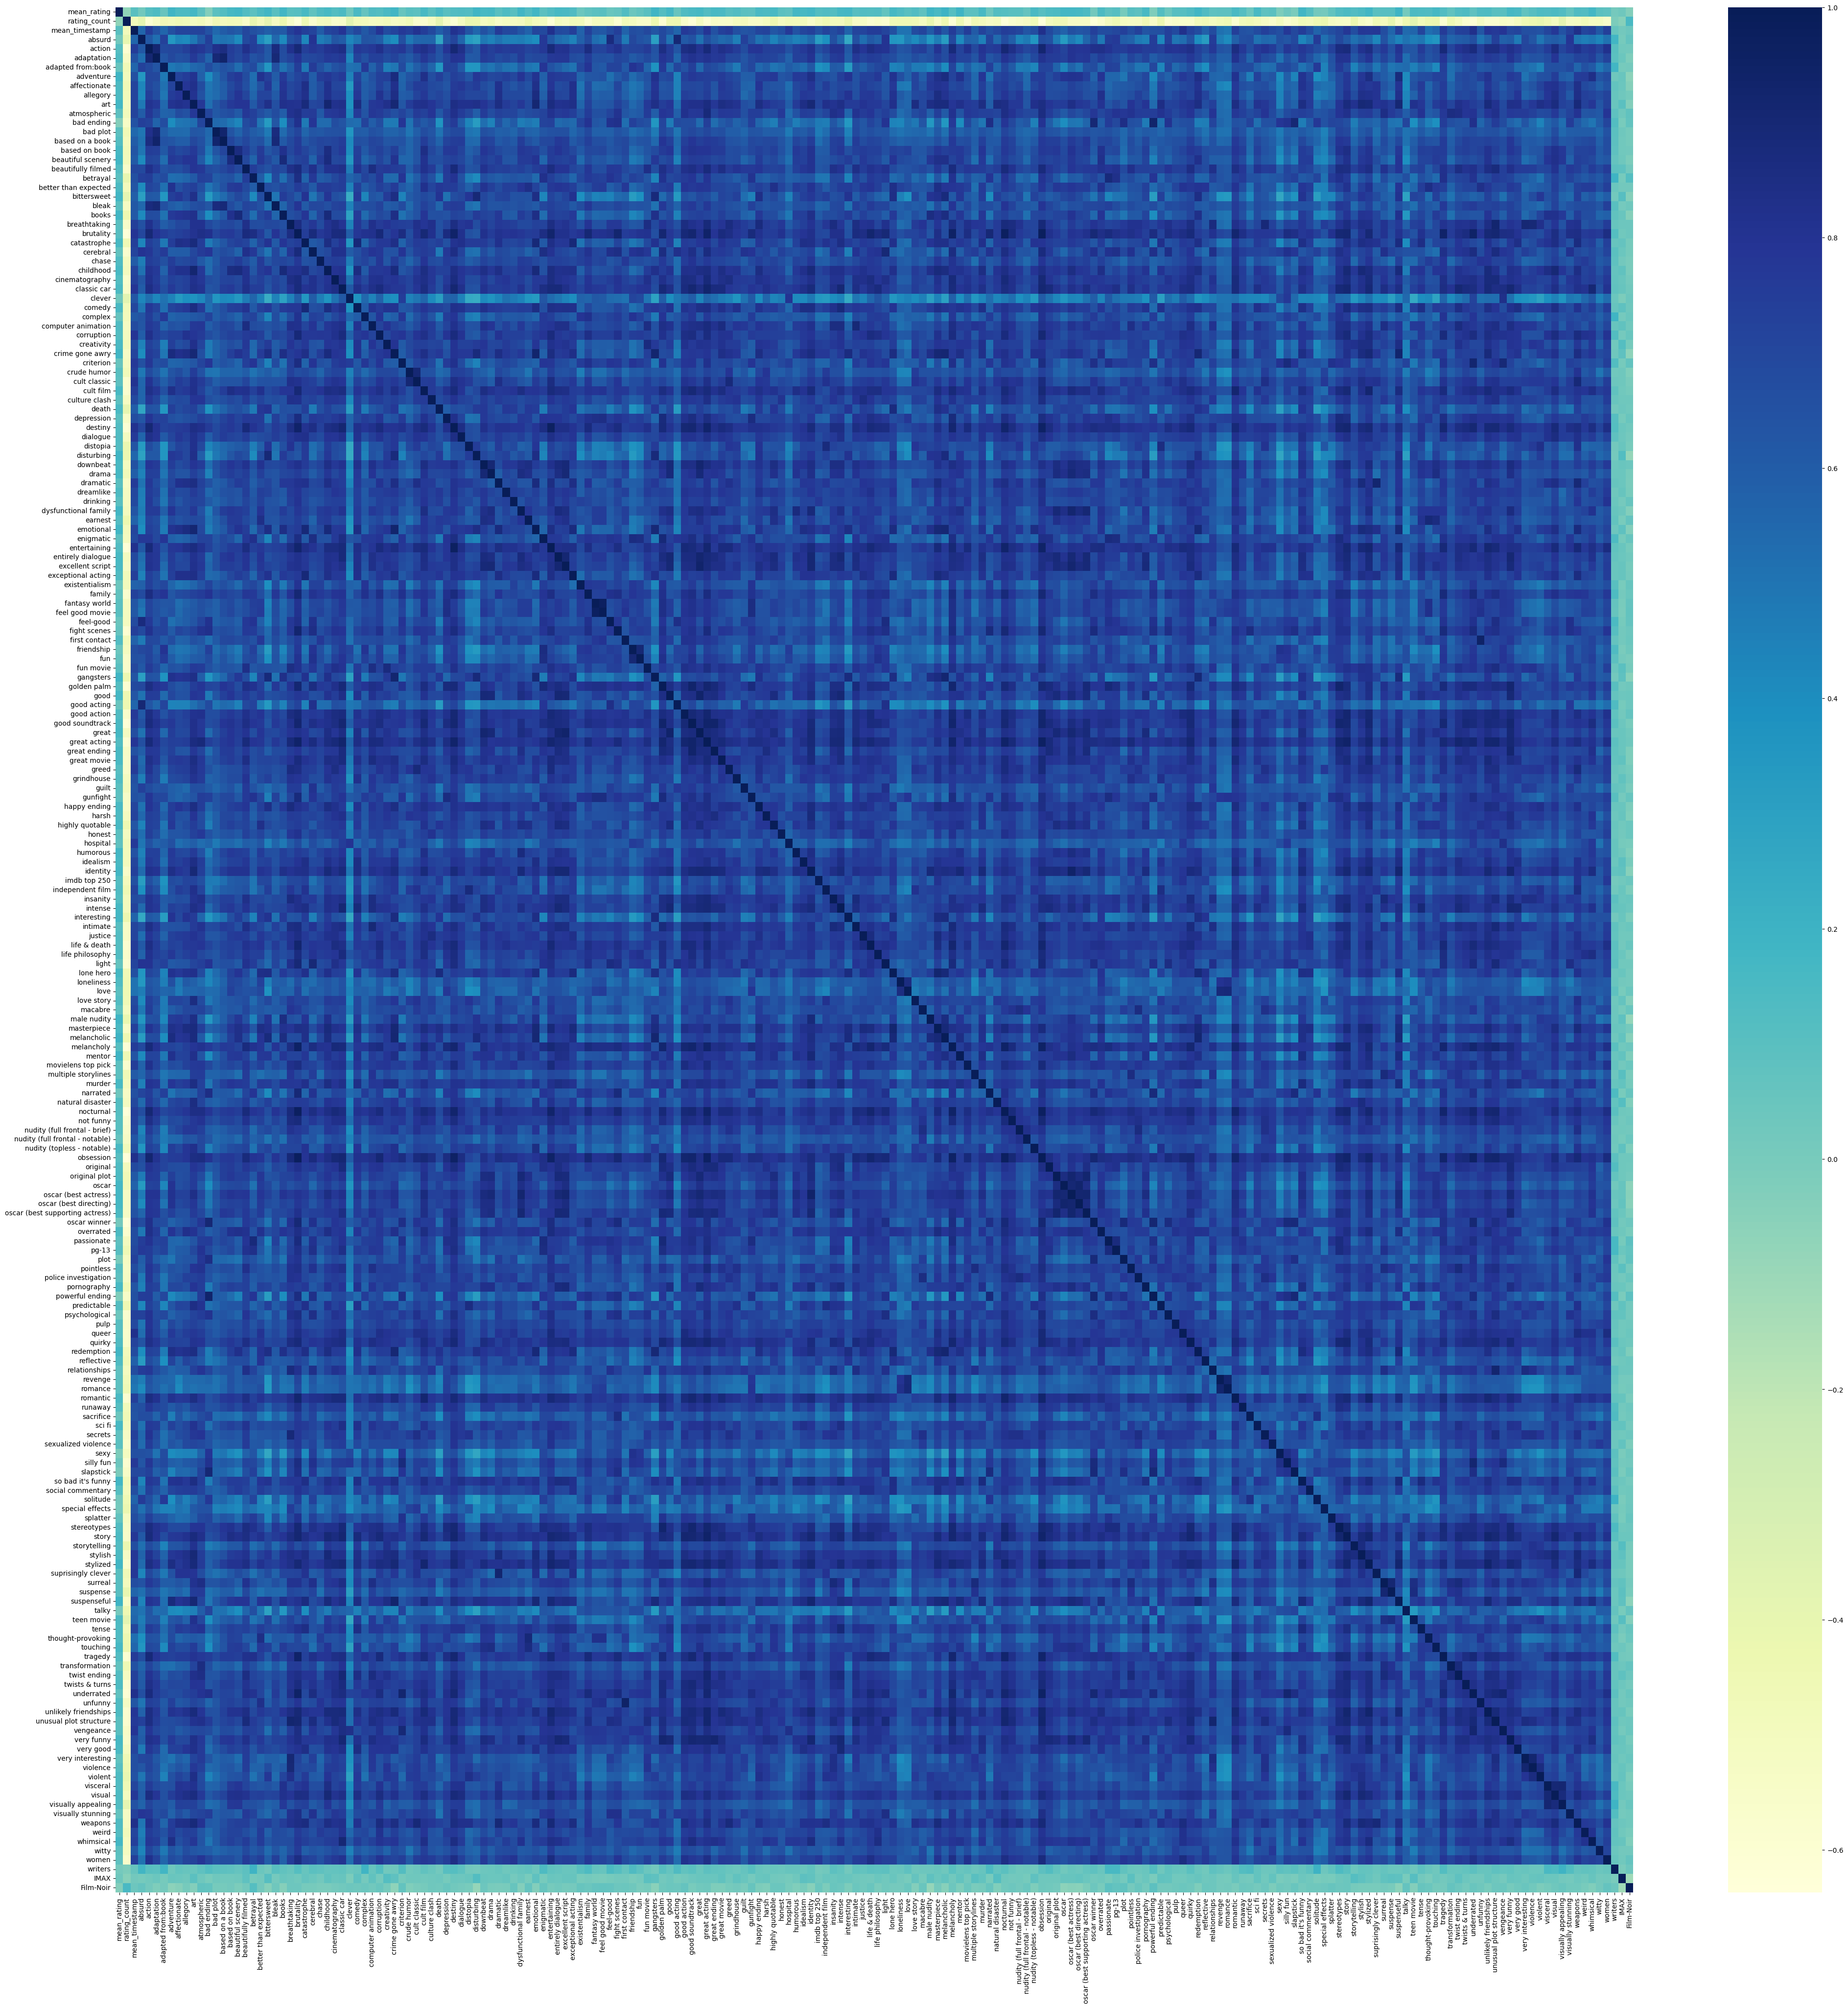

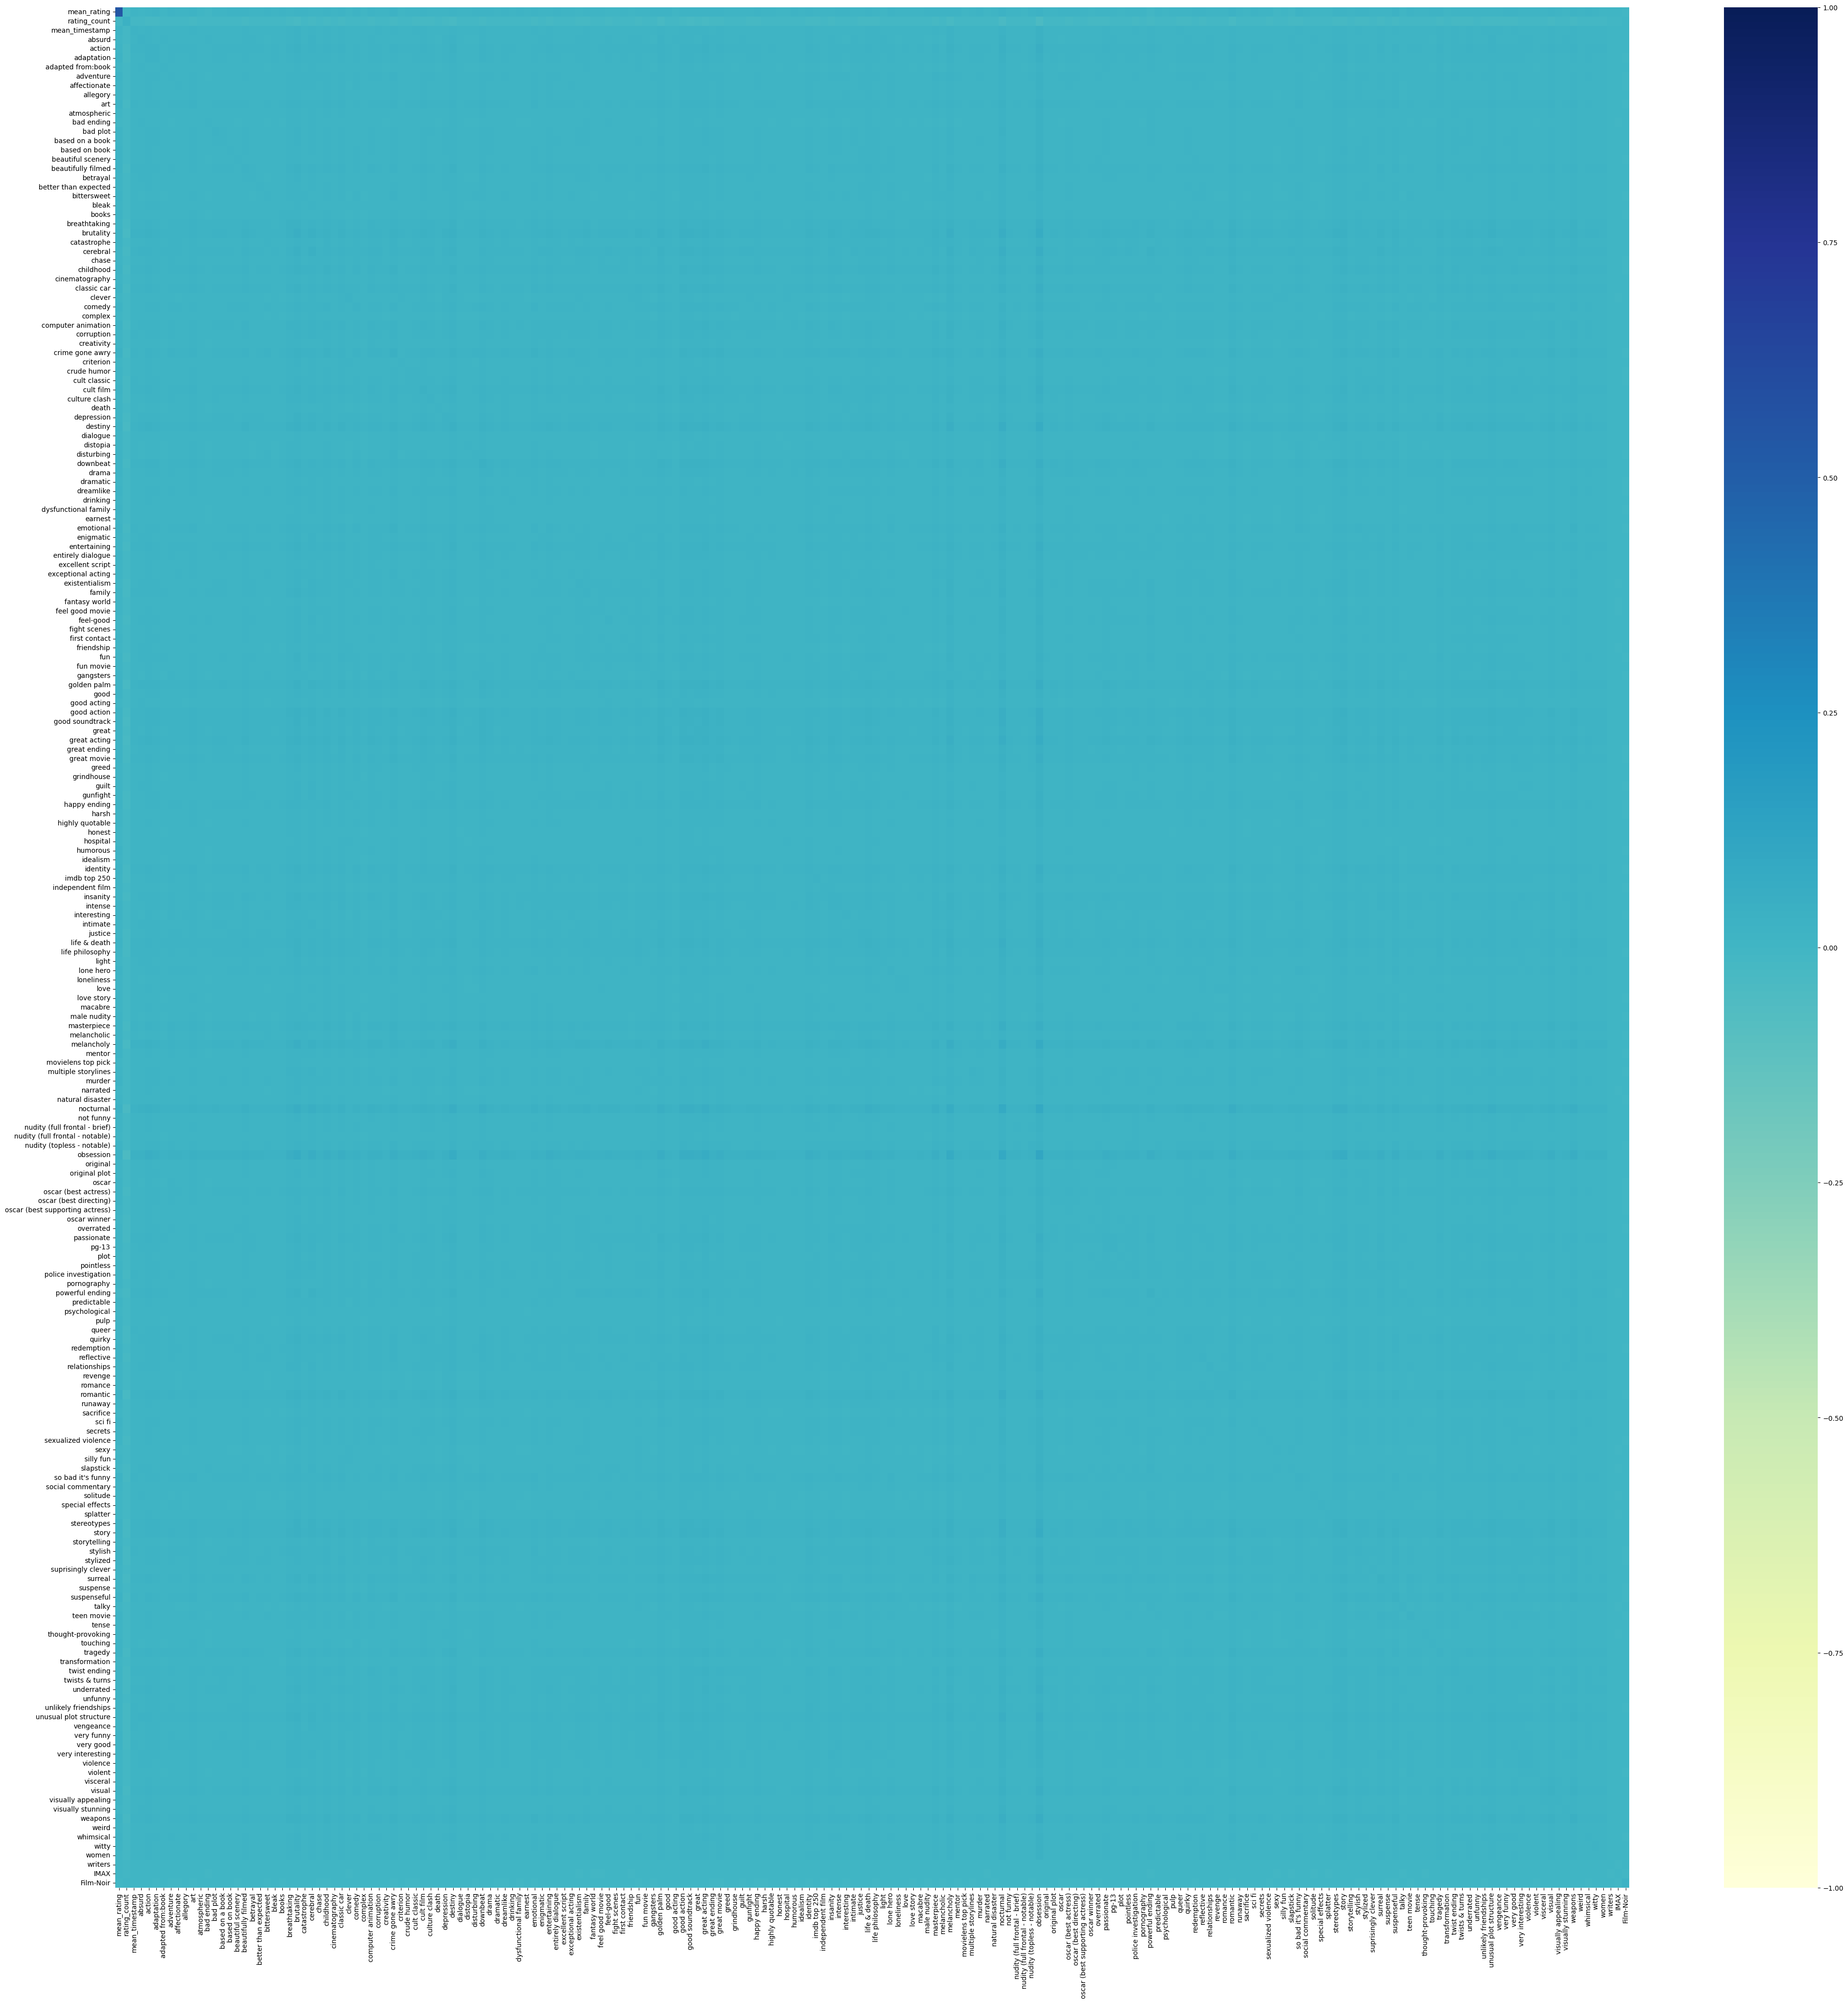

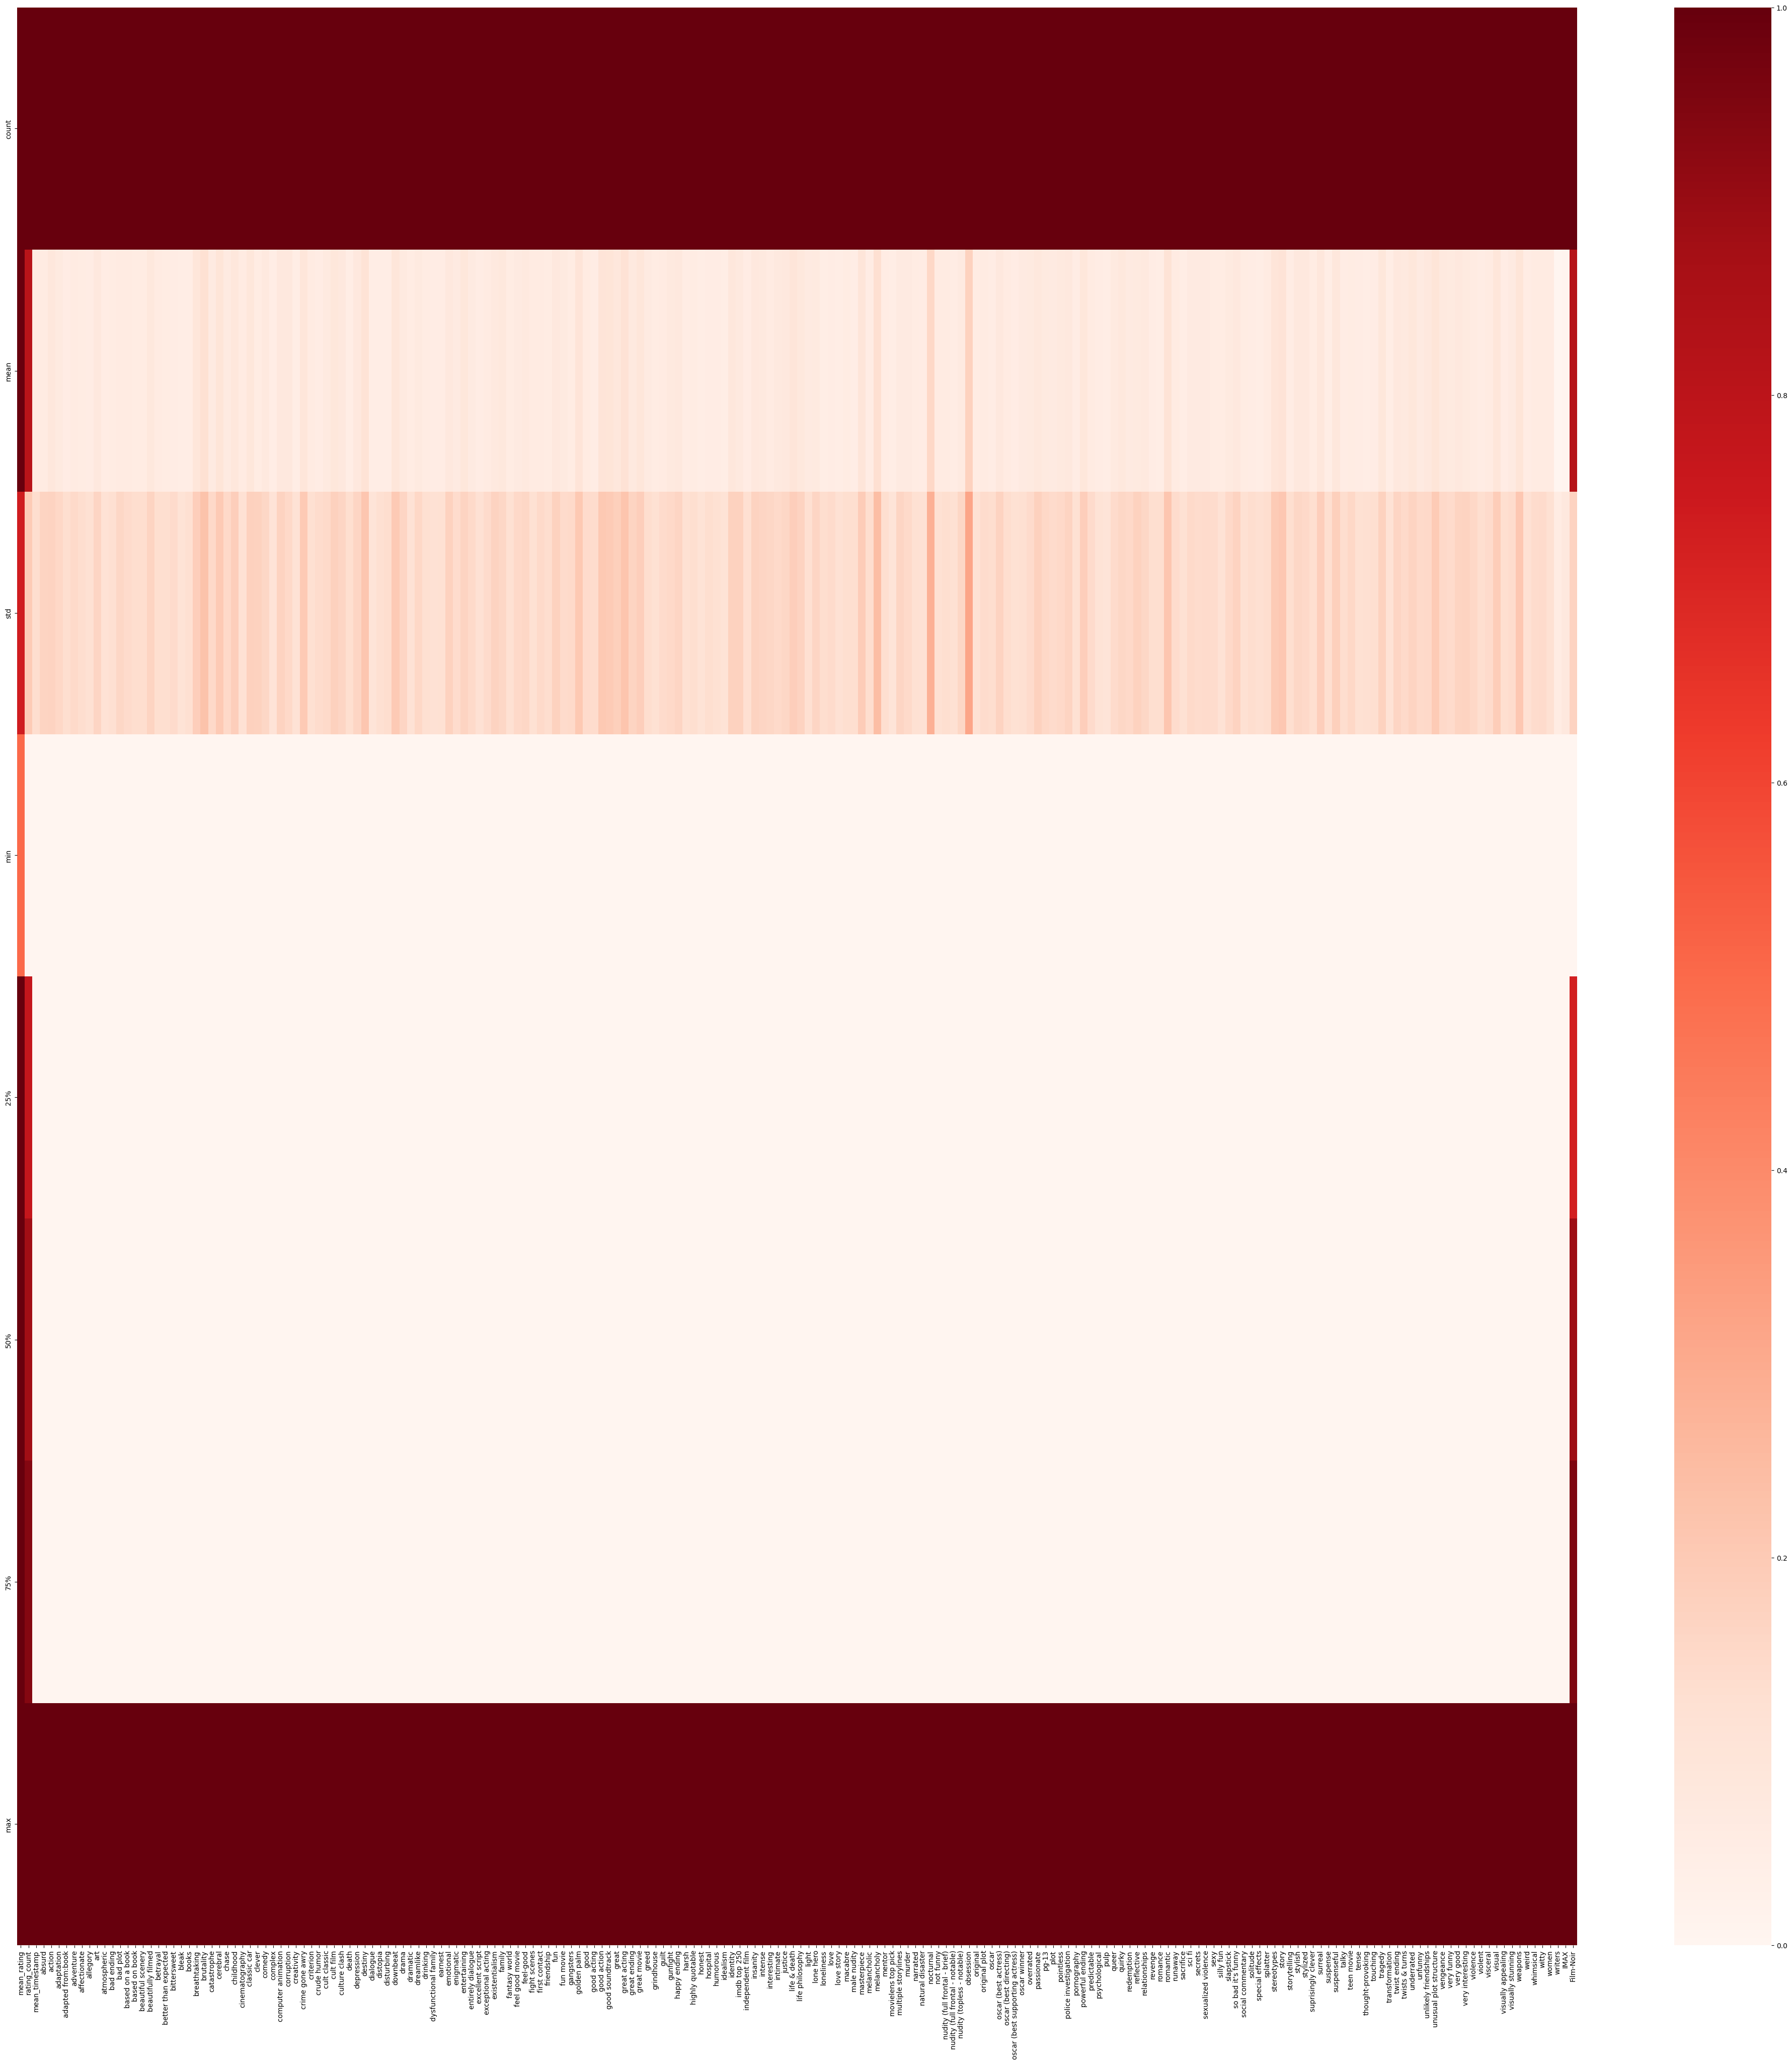

In [26]:
# compute analysis for other attributes
corr = df.corr()
cov = df.cov()
desc = df.describe()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(50, 50))
sns.heatmap(corr, cmap="YlGnBu")
plt.show()

# Plot the heatmap of the covariance matrix
plt.figure(figsize=(50, 50))
sns.heatmap(cov, cmap="YlGnBu", vmax=1, vmin=-1)
plt.show()

# Plot the table
plt.figure(figsize=(50, 50))
sns.heatmap(desc, cmap='Reds', vmax=1, vmin=0)
plt.show()



### PCA (Principal Component Analysis)

X shape: (58308, 203)
y shape: (58308,)
X_train shape: (52477, 203)
y_train shape: (52477,)
X_test shape: (5831, 203)
y_test shape: (5831,)
pca.mean_: [0.81142152 0.06002786 0.06212997 0.08567427 0.06929066 0.0517287
 0.06071664 0.05552075 0.05447088 0.07542758 0.05379368 0.05685379
 0.06117636 0.06036338 0.05697287 0.05480531 0.08140448 0.05921247
 0.0554605  0.05173513 0.0492593  0.05047146 0.09130613 0.12241521
 0.06433025 0.0981423  0.06532739 0.08538844 0.05866052 0.08628054
 0.05729937 0.07043232 0.04844834 0.07741722 0.07509295 0.04967859
 0.09244262 0.05984659 0.05341943 0.06931985 0.08898836 0.07464888
 0.05058695 0.07697938 0.11150573 0.04769576 0.04909528 0.04938969
 0.09151953 0.06710699 0.05518926 0.06921722 0.05720579 0.05139796
 0.05158889 0.07663697 0.06301041 0.08636594 0.06620955 0.05457673
 0.06241924 0.07384019 0.08032584 0.05477901 0.06620717 0.07292699
 0.06245494 0.06215006 0.05730113 0.0767516  0.06692345 0.05738059
 0.10238348 0.06016806 0.052567   0.10351565 0

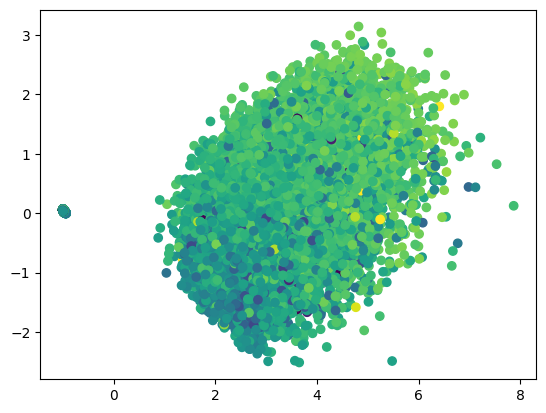

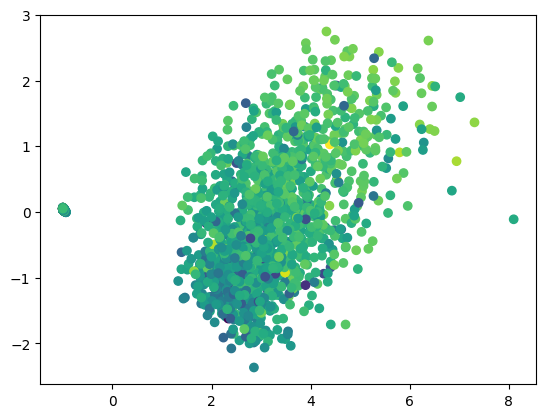

In [27]:
from sklearn import decomposition

df_PCA = df.copy()

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['mean_rating']), mean_rating_column, test_size=0.1, random_state=42)
print('X shape:',df.drop(columns=['mean_rating']).shape)
print('y shape:',mean_rating_column.shape)
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

pca = decomposition.PCA()
pca.fit(X_train)
print('pca.mean_:', pca.mean_)
print('pca.explained_variance_:', pca.explained_variance_)
print('pca.explained_variance_ratio_:', pca.explained_variance_ratio_)
print('pca.components_:', pca.components_)

X_train_t = pca.transform(X_train)
plt.scatter(X_train_t[:, 0], X_train_t[:, 1], c=y_train)
plt.show()
X_test_t = pca.transform(X_test)
plt.scatter(X_test_t[:, 0], X_test_t[:, 1], c=y_test)
plt.show()


## Modeling

#### Linear Regressor

In [28]:
""" # Split data
df2 = df.copy()
X = df2.drop(columns=['mean_rating'])
y = df['mean_rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) """

X_train = X_train_t
X_test = X_test_t


In [29]:
# Create Linear Regression model in sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create the model
LR_model = LinearRegression()

# Train the model on the training data
LR_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = LR_model.predict(X_test)
print('Coefficients: ', LR_model.coef_)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

display(y_test[:5])
display(y_pred[:5])


Coefficients:  [ 5.62845002e-02  2.31850986e-01  1.78165445e-01  1.25974175e-01
  1.74738701e-01 -3.92381721e-02 -5.70893719e-02  6.75576152e-02
  1.13716600e-01  1.10274122e-02 -1.36555649e-01  9.34331644e-02
  4.26706568e-02  5.63751824e-02  6.52450805e-02 -1.56157943e-01
 -2.15518433e-01 -3.26432554e-01 -1.96606305e-02 -4.04836802e-01
  2.39916184e-01  2.08367183e-01  7.52026868e-02  1.10596747e-01
 -1.71414100e-01  1.47159949e-01 -1.41274263e-01 -1.95353116e-01
 -3.33427227e-02 -8.42508291e-03  1.72773129e-01  1.99055298e-01
  2.09572820e-01 -1.02397385e-01  7.18816955e-02  1.69086536e-01
  6.77058317e-02  7.84948430e-02  1.19712641e-02 -1.50373661e-01
  2.72627312e-02 -1.72834965e-01 -1.90510911e-02 -1.25662386e-01
  1.66917063e-01 -1.03791926e-01  2.11036974e-01 -1.17471701e-02
 -7.52057768e-02  1.24766460e-01 -4.17590762e-02 -7.92790853e-02
 -1.31418472e-02 -4.77173041e-02 -1.48996381e-01  4.28702630e-02
 -6.65383124e-02 -3.69091778e-02 -2.08458730e-02 -7.15447674e-02
  1.850662

27301    2.446429
43385    2.388889
38475    3.357143
32002    3.500000
22307    3.530303
Name: mean_rating, dtype: float64

array([3.55216853, 3.02265328, 3.31958309, 3.02845407, 3.02298976])

#### Stochastic Gradient Descent

In [30]:
# Create Stochastic Gradient Descent model in sklearn
from sklearn.linear_model import SGDRegressor

# Create the model
SGD_model = SGDRegressor()

# Train the model on the training data
SGD_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = SGD_model.predict(X_test)
print('Coefficients: ', SGD_model.coef_)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

display(y_test[:5])
display(y_pred[:5])


Coefficients:  [ 0.05610777  0.22640312  0.17831951  0.12847599  0.17209448 -0.03718696
 -0.05771256  0.06651173  0.11428759  0.00908651 -0.13624233  0.09347295
  0.04256618  0.05516832  0.06787278 -0.1509222  -0.20476292 -0.30780915
 -0.02232349 -0.36954114  0.21516004  0.18637786  0.06192941  0.09556582
 -0.14448267  0.11769579 -0.11257735 -0.15213014 -0.0239914  -0.00367091
  0.12384768  0.1368177   0.14221318 -0.06478726  0.04576092  0.1084415
  0.04245993  0.04254402  0.00994452 -0.08784651  0.01557686 -0.10568912
 -0.01479464 -0.07474694  0.08479158 -0.0622324   0.11237596 -0.01083034
 -0.03830654  0.06238559 -0.01761463 -0.04307432 -0.00203923 -0.02775909
 -0.07712068  0.02474899 -0.03720675 -0.01368507 -0.00832069 -0.02619431
  0.07309924  0.01388214  0.03950034 -0.06051788  0.08041554 -0.07467522
 -0.0682726  -0.0342316   0.02335735  0.00796624 -0.02292609  0.03159032
 -0.03091804 -0.00275218  0.02268532 -0.00597103 -0.0390451  -0.00839618
  0.00795636 -0.01859958 -0.04864188 

27301    2.446429
43385    2.388889
38475    3.357143
32002    3.500000
22307    3.530303
Name: mean_rating, dtype: float64

array([3.5665665 , 3.01951841, 3.33766294, 3.028494  , 3.02004943])

#### SVM

In [31]:
# # Create SVM model in sklearn
# from sklearn.svm import SVR

# # Create the model
# SVM_model = SVR()

# # Train the model on the training data
# SVM_model.fit(X_train, y_train)

# # Evaluate the model on the test data
# y_pred = SVM_model.predict(X_test)
# print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

# display(y_test[:5])
# display(y_pred[:5])

### KNN

In [32]:
from sklearn.neighbors import KNeighborsRegressor

KNN_model = KNeighborsRegressor(n_neighbors=5)
KNN_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = KNN_model.predict(X_test)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

display(y_test[:5])
display(y_pred[:5])

Mean squared error: 0.59
Coefficient of determination: -0.08


27301    2.446429
43385    2.388889
38475    3.357143
32002    3.500000
22307    3.530303
Name: mean_rating, dtype: float64

array([3.        , 3.32595438, 3.33081745, 2.69      , 2.85310429])

### Decision Trees

In [33]:
from sklearn.tree import DecisionTreeRegressor

DT_model = DecisionTreeRegressor()
DT_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = DT_model.predict(X_test)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

display(y_test[:5])
display(y_pred[:5])

Mean squared error: 0.96
Coefficient of determination: -0.75


27301    2.446429
43385    2.388889
38475    3.357143
32002    3.500000
22307    3.530303
Name: mean_rating, dtype: float64

array([3.  , 3.25, 5.  , 3.  , 3.  ])

### Modeling the problem as classification

In [34]:
# bin y_train and y_test into 10 bins
y_train_binned = pd.cut(y_train, 10, labels=False)
y_test_binned = pd.cut(y_test, 10, labels=False)

print('Binned values:', np.unique(y_train_binned))
display(y_train_binned[:5])

# use the binned values to train the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score

RFC_classifier = RandomForestClassifier()
RFC_classifier.fit(X_train, y_train_binned)

y_pred = RFC_classifier.predict(X_test)

# evaluation of y_pred
print('Accuracy: %.2f' % accuracy_score(y_test_binned, y_pred))
print('Recall: %.2f' % recall_score(y_test_binned, y_pred, average='macro'))
print('Precision: %.2f' % precision_score(y_test_binned, y_pred, average='macro'))

display(y_test_binned[:5])
display(y_pred[:5])

Binned values: [0 1 2 3 4 5 6 7 8 9]


22371    7
39189    7
47380    9
10113    6
30628    7
Name: mean_rating, dtype: int64

Accuracy: 0.28
Recall: 0.14
Precision: 0.14


27301    4
43385    4
38475    6
32002    6
22307    6
Name: mean_rating, dtype: int64

array([6, 6, 5, 6, 5])